## Truth-matched signal candidates using reco jets matched to gen b-quarks from Higgs decays

In [8]:
import math
import uproot
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# 4b or bbaa
final_state = "4b"
batch = "0"

# File paths: left plot = signal, right plot = background
# FILE_PATH_SIGNAL = f"/vols/cms/us322/events_{final_state}/02b_final_events_{final_state}/signal_sm/batch_{batch}/run_01_decayed_1/tag_1_pythia8_events_delphes.root"
# FILE_PATH_BACKGROUND = f"/vols/cms/us322/events_{final_state}/02b_final_events_{final_state}/background/batch_{batch}/run_01/tag_1_pythia8_events_delphes.root"

FILE_PATH_SIGNAL = f"/vols/cms/us322/testing_delphes/signal_sm/batch_0/run_01_decayed_1/tag_1_pythia8_events_delphes.root"
#FILE_PATH_BACKGROUND = f"/vols/cms/us322/testing_delphes/background/batch_0/run_01/tag_1_pythia8_events_delphes.root"

# Read minimal branches for reco jets and truth particles
branches_truthmatch = [
    # Reco jets
    "Jet/Jet.PT", "Jet/Jet.Eta", "Jet/Jet.Phi", "Jet/Jet.BTag",
    # Truth particles (Delphes Particle branch)
    "Particle/Particle.PID", "Particle/Particle.M1", "Particle/Particle.M2",
    "Particle/Particle.Status", "Particle/Particle.PT", "Particle/Particle.Eta", "Particle/Particle.Phi",
]

with uproot.open(FILE_PATH_SIGNAL) as f_sig_tm:
    arrays_sig_tm = f_sig_tm["Delphes"].arrays(branches_truthmatch, library="ak")

print(f"Loaded for truth-matching: {len(arrays_sig_tm)} signal events")

Loaded for truth-matching: 5000 signal events


In [10]:
def compute_candidate_kinematics(pt1, pt2, eta1, eta2, phi1, phi2):
    """
    Computes candidate four-vector kinematics from two jet inputs.
    """
    E1  = pt1 * np.cosh(eta1)
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)

    E2  = pt2 * np.cosh(eta2)
    px2 = pt2 * np.cos(phi2)
    py2 = pt2 * np.sin(phi2)
    pz2 = pt2 * np.sinh(eta2)

    E  = E1 + E2
    px, py, pz = px1 + px2, py1 + py2, pz1 + pz2

    eps = 1e-12
    candidate_pt  = np.sqrt(px**2 + py**2)
    candidate_p = np.sqrt(px**2 + py**2 + pz**2)
    candidate_phi = np.arctan2(py, px)
    candidate_eta = 0.5 * np.log((candidate_p+pz + eps)/(candidate_p-pz + eps))
    candidate_mass = np.sqrt(max(E**2 - (px**2+py**2+pz**2), 0))
    candidate_rapidity = 0.5 * np.log((E+pz)/(E-pz)) if (E-pz)!=0 else 0.0

    return candidate_mass, candidate_pt, (E,px,py,pz), candidate_eta, candidate_phi, candidate_rapidity, candidate_p


In [11]:
def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + math.pi) % (2*math.pi) - math.pi
    deta = eta1 - eta2
    return math.hypot(deta, dphi)

In [12]:
truthmatch_cand1_masses = []
truthmatch_cand2_masses = []

num_events = len(arrays_sig_tm)

for evt in range(num_events):
    # Reco jets
    r_pt  = np.array(arrays_sig_tm["Jet/Jet.PT"][evt])
    r_eta = np.array(arrays_sig_tm["Jet/Jet.Eta"][evt])
    r_phi = np.array(arrays_sig_tm["Jet/Jet.Phi"][evt])

    if len(r_pt) < 2:
        continue

    # Sort reco jets by pT desc (optional, helpful for the described matching order)
    reco_order = np.argsort(r_pt)[::-1]
    r_pt, r_eta, r_phi = r_pt[reco_order], r_eta[reco_order], r_phi[reco_order]

    # Truth particles
    p_pid = np.array(arrays_sig_tm["Particle/Particle.PID"][evt])
    p_m1  = np.array(arrays_sig_tm["Particle/Particle.M1"][evt])
    p_m2  = np.array(arrays_sig_tm["Particle/Particle.M2"][evt])
    p_pt  = np.array(arrays_sig_tm["Particle/Particle.PT"][evt])
    p_eta = np.array(arrays_sig_tm["Particle/Particle.Eta"][evt])
    p_phi = np.array(arrays_sig_tm["Particle/Particle.Phi"][evt])

    if len(p_pid) == 0:
        continue

    # Identify gen b-quarks from Higgs decays using mother PID == 25
    gen_b_indices = []
    gen_b_mother = []
    for i in range(len(p_pid)):
        pid = int(p_pid[i])
        if abs(pid) != 5:
            continue
        mom = -1
        # Prefer first mother if valid
        if 0 <= p_m1[i] < len(p_pid) and int(p_pid[p_m1[i]]) == 25:
            mom = int(p_m1[i])
        elif 0 <= p_m2[i] < len(p_pid) and int(p_pid[p_m2[i]]) == 25:
            mom = int(p_m2[i])
        if mom >= 0:
            gen_b_indices.append(i)
            gen_b_mother.append(mom)

    if len(gen_b_indices) < 2:
        continue

    # Sort gen b-quarks by pT descending as requested
    gen_order = sorted(range(len(gen_b_indices)), key=lambda k: p_pt[gen_b_indices[k]], reverse=True)
    gen_b_indices = [gen_b_indices[k] for k in gen_order]
    gen_b_mother  = [gen_b_mother[k]  for k in gen_order]

    # Greedy matching: each reco jet can be matched to at most one gen b-quark
    used_reco = set()
    matches = []  # list of tuples (gen_idx, reco_idx, mother_idx)
    for gi, gen_idx in enumerate(gen_b_indices):
        best_dr = 1e9
        best_rj = -1
        for rj in range(len(r_pt)):
            if rj in used_reco:
                continue
            dr = delta_r(p_eta[gen_idx], p_phi[gen_idx], r_eta[rj], r_phi[rj])
            if dr < best_dr:
                best_dr = dr
                best_rj = rj
        if best_rj >= 0 and best_dr < 0.2:
            matches.append((gen_idx, best_rj, gen_b_mother[gi]))
            used_reco.add(best_rj)

    # Group matches by Higgs mother index and require exactly 2 matches per Higgs
    mother_to_reco = {}
    for _, reco_idx, mom in matches:
        mother_to_reco.setdefault(mom, []).append(reco_idx)

    # We expect two Higgs (two mothers with two matches each)
    higgs_reco_pairs = []
    for mom, reco_list in mother_to_reco.items():
        if len(reco_list) == 2:
            higgs_reco_pairs.append(tuple(reco_list))

    if len(higgs_reco_pairs) < 2:
        continue

    # Build two Higgs candidates from matched reco jets
    (h1_j1, h1_j2), (h2_j1, h2_j2) = higgs_reco_pairs[:2]

    m1, pt1, _, _, _, _, _ = compute_candidate_kinematics(
        r_pt[h1_j1], r_pt[h1_j2], r_eta[h1_j1], r_eta[h1_j2], r_phi[h1_j1], r_phi[h1_j2]
    )
    m2, pt2, _, _, _, _, _ = compute_candidate_kinematics(
        r_pt[h2_j1], r_pt[h2_j2], r_eta[h2_j1], r_eta[h2_j2], r_phi[h2_j1], r_phi[h2_j2]
    )

    # Order by candidate pT so that candidate 1 has higher pT
    if pt2 > pt1:
        m1, m2 = m2, m1
        pt1, pt2 = pt2, pt1

    truthmatch_cand1_masses.append(m1)
    truthmatch_cand2_masses.append(m2)

In [13]:
truthmatch_cand1_masses = np.array(truthmatch_cand1_masses)
truthmatch_cand2_masses = np.array(truthmatch_cand2_masses)

print(f"Truth-matched candidates (signal): {len(truthmatch_cand1_masses)} events")

Truth-matched candidates (signal): 878 events


Truth-matched signal means: m1=100.24 GeV, m2=92.24 GeV


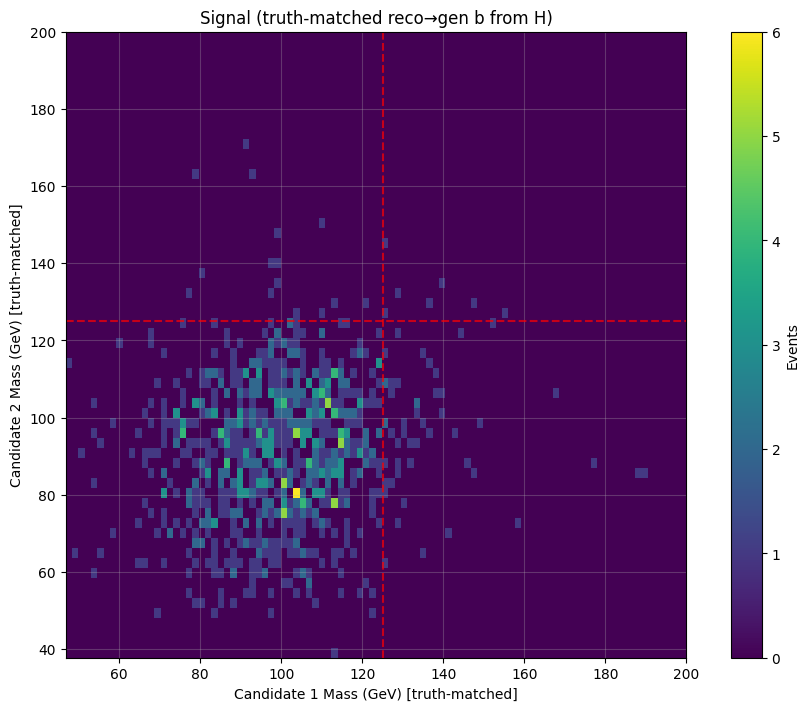

In [14]:
# Plot truth-matched masses for signal and report means
fig, ax = plt.subplots(1, 1, figsize=(8, 7), constrained_layout=True)

h = ax.hist2d(truthmatch_cand1_masses, truthmatch_cand2_masses, bins=100, cmap='viridis')
# Set x and y limits to the minimum and maximum of the data
ax.set_xlim(np.min(truthmatch_cand1_masses), 200)
ax.set_ylim(np.min(truthmatch_cand2_masses), 200)
ax.set_xlabel('Candidate 1 Mass (GeV) [truth-matched]')
ax.set_ylabel('Candidate 2 Mass (GeV) [truth-matched]')
ax.set_title('Signal (truth-matched reco→gen b from H)')
ax.grid(True, alpha=0.3)
ax.axvline(x=125, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=125, color='red', linestyle='--', alpha=0.7)
fig.colorbar(h[3], ax=ax, label='Events')

plt.savefig('higgs_candidate_masses_signal_truthmatched_highres.pdf', dpi=200)

print(f"Truth-matched signal means: m1={np.mean(truthmatch_cand1_masses):.2f} GeV, m2={np.mean(truthmatch_cand2_masses):.2f} GeV")